In [3]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchvision import transforms
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt

import torch.nn.functional as F

# -------------------------
# Dataset
# -------------------------
class StepwiseDeepVODataset(Dataset):
    def __init__(self, data_dir, img_size=(192, 640), seq_len=10, transform=None):
        self.files = sorted(os.listdir(data_dir))
        self.data_dir = data_dir
        self.img_size = img_size
        self.seq_len = seq_len
        self.transform = transform
        
    def __len__(self):
        return len(self.files) - self.seq_len  # Subtract seq_len to avoid index overflow

    def __getitem__(self, idx):
        # Load sequence of images
        img_seq = []
        for i in range(self.seq_len):
            item = np.load(os.path.join(self.data_dir, self.files[idx + i]), allow_pickle=True)
            img1 = cv2.imread(item['img1'].item())
            img2 = cv2.imread(item['img2'].item())

            img1 = cv2.resize(img1, self.img_size).transpose(2, 0, 1) / 255.0
            img2 = cv2.resize(img2, self.img_size).transpose(2, 0, 1) / 255.0

            img_seq.append(np.concatenate([img1, img2], axis=0))  # Concatenate img1 and img2

        image_seq = np.stack(img_seq, axis=0)  # Shape: (seq_len, 6, H, W)
        pose = item['pose']  # Pose for the last frame in the sequence

        return torch.tensor(image_seq, dtype=torch.float32), torch.tensor(pose, dtype=torch.float32)

# -------------------------
# Model
# -------------------------
class DeepVO_LSTM(nn.Module):
    def __init__(self, input_size=(192, 640), hidden_size=256, num_layers=2, seq_len=10):
        super(DeepVO_LSTM, self).__init__()
        self.seq_len = seq_len  # The number of frames in each sequence

        # Convolutional layers (same as before)
        self.conv1 = nn.Conv2d(6, 64, kernel_size=7, stride=2, padding=3)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=2)
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1)
        self.relu = nn.ReLU()

        # Dynamically compute the flattened size after conv layers
        dummy_input = torch.zeros(1, 6, *input_size)
        with torch.no_grad():
            x = self.relu(self.conv1(dummy_input))
            x = self.relu(self.conv2(x))
            x = self.relu(self.conv3(x))
            x = self.relu(self.conv4(x))
            conv_out_size = x.view(1, -1).shape[1]

        # LSTM layer
        self.lstm = nn.LSTM(input_size=conv_out_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)

        # Fully connected layers to predict the pose
        self.fc1 = nn.Linear(hidden_size, 1000)
        self.fc2 = nn.Linear(1000, 6)  # 3 for translation, 3 for rotation (Euler angles)

    def forward(self, x):
        # x is of shape (batch_size, seq_len, 6, H, W)
        batch_size, seq_len, _, _, _ = x.size()

        # Flatten the input to (batch_size * seq_len, 6, H, W) for processing
        x = x.reshape(batch_size * seq_len, 6, x.size(3), x.size(4))  # Replaced view() with reshape()

        # Pass through convolutional layers
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))

        # Flatten the output of convolutional layers
        x = x.reshape(batch_size * seq_len, -1)  # Replaced view() with reshape()

        # Now x is of shape (batch_size * seq_len, conv_out_size)
        # Pass through LSTM
        x = x.reshape(batch_size, seq_len, -1)  # Reshape back to (batch_size, seq_len, conv_out_size)
        lstm_out, _ = self.lstm(x)  # lstm_out is of shape (batch_size, seq_len, hidden_size)

        # Take the last output from the LSTM (for the last frame in the sequence)
        x = lstm_out[:, -1, :]  # (batch_size, hidden_size)

        # Fully connected layers
        x = self.relu(self.fc1(x))
        return self.fc2(x)  # Output pose (translation and rotation)



# -------------------------
# Integrate and Plot
# -------------------------
def integrate_poses(y_output):
    # Initialize the global trajectory starting from origin (0, 0, 0)
    positions = [np.zeros(3)]
    curr_rot = R.identity()  # Identity rotation (no rotation at the beginning)
    curr_pos = np.zeros(3)  # Starting position

    # Iterate through each pose in the sequence
    for i in range(y_output.shape[0]):
        dpos = y_output[i, :3]  # First 3 are position deltas (dx, dy, dz)
        drot = y_output[i, 3:]  # Last 3 are rotation deltas (Euler angles)

        # Apply rotation to position delta
        global_dpos = curr_rot.apply(dpos)
        curr_pos += global_dpos  # Update current position with the rotated delta

        # Append the new global position to the trajectory list
        positions.append(curr_pos.copy())

        # Update the current rotation with the delta rotation
        dR = R.from_euler('xyz', drot, degrees=False)  # Apply Euler angle rotation
        curr_rot = curr_rot * dR  # Update rotation

    return np.array(positions)  # Return the integrated trajectory


def plot_trajectory(positions):
    x, y, z = positions[:, 0], positions[:, 1], positions[:, 2]
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(x, y, z)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()

def geodesic_loss(pred_rot, true_rot):
    # Normalize quaternions
    pred_rot = F.normalize(pred_rot, p=2, dim=-1)
    true_rot = F.normalize(true_rot, p=2, dim=-1)

    # Compute the dot product of the predicted and true quaternions
    dot_prod = torch.sum(pred_rot * true_rot, dim=-1)
    
    # Clamping to avoid numerical issues (dot_prod could slightly exceed 1)
    dot_prod = torch.clamp(dot_prod, -1.0, 1.0)
    
    # Compute geodesic distance (angle) between quaternions
    angle = 2 * torch.acos(torch.abs(dot_prod))
    
    # Loss is the mean angular distance
    return torch.mean(angle)

def translation_loss(pred_translation, true_translation):
    return F.mse_loss(pred_translation, true_translation)

def combined_loss(pred, true):
    pred_translation, pred_rotation = pred[:, :3], pred[:, 3:]
    true_translation, true_rotation = true[:, :3], true[:, 3:]
    
    # Compute translation loss (Euclidean distance)
    translation_loss_val = translation_loss(pred_translation, true_translation)
    
    # Compute rotation loss (geodesic loss)
    rotation_loss_val = geodesic_loss(pred_rotation, true_rotation)
    
    # Total loss as a weighted sum
    total_loss = translation_loss_val + rotation_loss_val
    return total_loss

# -------------------------
# Training and Testing
# -------------------------
def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        pred = model(X)  # Model now predicts for the entire sequence
        loss = combined_loss(pred, y)  # Calculate loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def test(model, dataloader, device):
    model.eval()
    preds = []
    with torch.no_grad():
        for X, _ in dataloader:
            X = X.to(device)
            pred = model(X)
            preds.append(pred.cpu())
    return torch.stack(preds)



device = 'cuda' if torch.cuda.is_available() else 'cpu'

# -------------------------
# Main
# -------------------------

# Initialize dataset and data loader
#train_dataset = StepwiseDeepVODataset("data/train/05", seq_len=10)  # Adjusted for sequence length
#train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

import torch
from torch.utils.data import Subset
import numpy as np

# Load the full dataset
train_dataset = StepwiseDeepVODataset("data/train/05", seq_len=10)

# Calculate the number of samples corresponding to 0.1% of the dataset
total_samples = len(train_dataset)
subset_size = int(total_samples * 0.005)  # 0.1% of the data

# Generate a list of random indices for the subset
indices = torch.randperm(total_samples).tolist()[:subset_size]

# Create a subset using the indices
train_subset = Subset(train_dataset, indices)

# Create the DataLoader for the subset
train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)

# Initialize model and move to device
model = DeepVO_LSTM(input_size=(192, 640)).to(device)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Loss function (updated to use combined_loss)
def criterion(pred, true):
    return combined_loss(pred, true)

# -------------------------------
# Load checkpoint if it exists
# -------------------------------
os.makedirs("checkpoints1_lstm", exist_ok=True)
ckpt_path = "checkpoints1_lstm/deepvo_checkpoint.pt"
start_epoch = 0

# Load checkpoint if it exists
if os.path.exists(ckpt_path):
    checkpoint = torch.load(ckpt_path)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    start_epoch = checkpoint["epoch"] + 1
    print(f"Loaded checkpoint from epoch {start_epoch}")
else:
    print("Starting training from scratch")

# -------------------------------
# Training loop
# -------------------------------
for epoch in range(start_epoch, 300):
    # Train model for one epoch
    loss = train(model, train_loader, optimizer, criterion, device)
    print(f"Epoch {epoch}, Loss: {loss:.4f}")
    
    # Save checkpoint
    torch.save({
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict()
    }, ckpt_path)
    
    # Save epoch-specific model checkpoint
    torch.save(model.state_dict(), f"checkpoints1_lstm/deepvo_epoch{epoch}.pt")


OutOfMemoryError: CUDA out of memory. Tried to allocate 484.00 MiB. GPU 0 has a total capacity of 7.75 GiB of which 3.44 MiB is free. Process 406672 has 3.05 GiB memory in use. Process 406642 has 2.58 GiB memory in use. Process 409370 has 2.09 GiB memory in use. Of the allocated memory 1.79 GiB is allocated by PyTorch, and 148.03 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

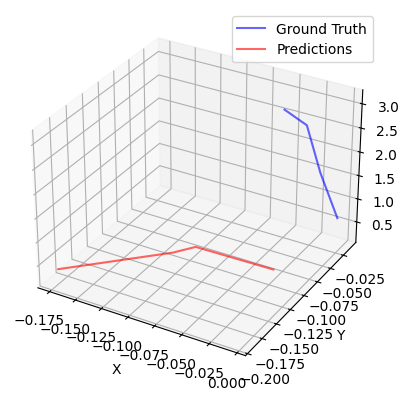

In [4]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.transform import Rotation as R

# -------------------------
# Plot the Predicted vs Ground Truth Trajectories
# -------------------------
def plot_pred_vs_gt(pred_positions, gt_positions):
    # Plotting in 3D
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Ground Truth Trajectory (Blue)
    ax.plot(gt_positions[:, 0], gt_positions[:, 1], gt_positions[:, 2], label='Ground Truth', color='b', alpha=0.6)
    
    # Predicted Trajectory (Red)
    ax.plot(pred_positions[:, 0], pred_positions[:, 1], pred_positions[:, 2], label='Predictions', color='r', alpha=0.6)
    
    # Labels and Title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()
    
    plt.show()

# -------------------------
# Testing Function to Generate Predictions
# -------------------------
def get_predictions(model, dataloader, device):
    model.eval()
    all_pred_positions = []
    all_gt_positions = []

    # Initialize the position and rotation for the first chunk (both GT and Pred)
    prev_gt_pos = np.zeros(3)
    prev_gt_rot = R.identity()

    prev_pred_pos = np.zeros(3)
    prev_pred_rot = R.identity()

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            
            # Generate predictions from the model
            pred = model(X)  # Output is (batch_size, 6) -> (dx, dy, dz, droll, dpitch, dyaw)
            
            # Integrate the ground truth and predicted poses
            gt_positions = integrate_poses(y.cpu().numpy())  # Ground truth trajectory
            pred_positions = integrate_poses(pred.cpu().numpy())  # Predicted trajectory

            # Teleport the ground truth chunk
            gt_positions[1:] += prev_gt_pos  # Offset by previous chunk's end position
            gt_rot = prev_gt_rot.apply(gt_positions[1:] - gt_positions[0]) + gt_positions[0]  # Apply previous rotation
            
            all_gt_positions.append(gt_rot)

            # Teleport the predicted chunk (same logic as GT)
            pred_positions[1:] += prev_pred_pos  # Offset by previous chunk's end position
            pred_rot = prev_pred_rot.apply(pred_positions[1:] - pred_positions[0]) + pred_positions[0]  # Apply previous rotation
            
            all_pred_positions.append(pred_rot)

            # Update previous position and rotation for both GT and Pred
            prev_gt_pos = gt_positions[-1]
            prev_gt_rot = R.from_euler('xyz', y[-1, 3:].cpu().numpy(), degrees=False)

            prev_pred_pos = pred_positions[-1]
            prev_pred_rot = R.from_euler('xyz', pred[-1, 3:].cpu().numpy(), degrees=False)

    # Flatten the list of positions for both GT and Pred
    all_pred_positions = np.concatenate(all_pred_positions, axis=0)
    all_gt_positions = np.concatenate(all_gt_positions, axis=0)
    
    return all_pred_positions, all_gt_positions

# -------------------------
# Main for Prediction and Plotting
# -------------------------
# Assuming the model is trained and we have a DataLoader (train_loader for training data, or test_loader for test data)
pred_positions, gt_positions = get_predictions(model, train_loader, device)

# Now plot the results (Predicted vs Ground Truth Trajectories)
plot_pred_vs_gt(pred_positions, gt_positions)
